# GoogLeNet

前面讲的 VGG 是 2014 年 ImageNet 比赛的亚军，那么冠军是谁呢？就是接下来要讲的 GoogLeNet，这是 Google 的研究人员提出的网络结构，在当时取得了非常大的影响，因为网络的结构变得前所未有，它颠覆了大家对卷积网络的串联的印象和固定做法，采用了一种非常有效的 Inception 模块，得到了比 VGG 更深的网络结构，但是却比 VGG 的参数更少，因为其去掉了后面的全连接层，所以参数大大减少，同时有了很高的计算效率。

![inception2_improved.jpeg](images/inception2_improved.jpeg)

这是 googlenet 的网络示意图，下面我们介绍一下其作为创新的 Inception 模块。

## Inception 模块

在上面的网络中，我们看到了多个四个并行卷积的层，这些四个卷积并行的层就是 Inception 模块


一个 inception 模块的四个并行线路如下：
1. 一个 1 x 1 的卷积，一个小的感受野进行卷积提取特征
2. 一个 1 x 1 的卷积加上一个 3 x 3 的卷积，1 x 1 的卷积降低输入的特征通道，减少参数计算量，然后接一个 3 x 3 的卷积做一个较大感受野的卷积
3. 一个 1 x 1 的卷积加上一个 5 x 5 的卷积，作用和第二个一样
4. 一个 3 x 3 的最大池化加上 1 x 1 的卷积，最大池化改变输入的特征排列，1 x 1 的卷积进行特征提取

最后将四个并行线路得到的特征在通道这个维度上拼接在一起，下面是PyTorch的实现一下

In [9]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torchvision.datasets import CIFAR10
from torchvision import transforms as tfs

In [2]:
# 定义一个卷积加一个 relu 激活函数和一个 batchnorm 作为一个基本的层结构
def Conv_ReLU(in_channel, out_channel, kernel, stride=1, padding=0):
    layer = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel, stride, padding),
        nn.BatchNorm2d(out_channel, eps=1e-3),
        nn.ReLU(True)
    )
    return layer

In [3]:
class Inception(nn.Module):
    def __init__(self, in_channel, out1_1, out2_1, out2_3, out3_1, out3_5, out4_1):
        super(Inception, self).__init__()
        # 第一条线路
        self.branch1x1 = Conv_ReLU(in_channel, out1_1, 1)
        
        # 第二条线路
        self.branch3x3 = nn.Sequential( 
            Conv_ReLU(in_channel, out2_1, 1),
            Conv_ReLU(out2_1, out2_3, 3, padding=1)
        )
        
        # 第三条线路
        self.branch5x5 = nn.Sequential(
            Conv_ReLU(in_channel, out3_1, 1),
            Conv_ReLU(out3_1, out3_5, 5, padding=2)
        )
        
        # 第四条线路
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            Conv_ReLU(in_channel, out4_1, 1)
        )
        
    def forward(self, x):
        f1 = self.branch1x1(x)
        f2 = self.branch3x3(x)
        f3 = self.branch5x5(x)
        f4 = self.branch_pool(x)
        output = torch.cat((f1, f2, f3, f4), dim=1)
        return output

In [4]:
test_net = Inception(3, 64, 48, 64, 64, 96, 32)
test_x = Variable(torch.zeros(1, 3, 96, 96))
print('input shape: {} x {} x {}'.format(test_x.shape[1], test_x.shape[2], test_x.shape[3]))
test_y = test_net(test_x)
print('output shape: {} x {} x {}'.format(test_y.shape[1], test_y.shape[2], test_y.shape[3]))

input shape: 3 x 96 x 96
output shape: 256 x 96 x 96


可以看到输入经过了 Inception 模块之后，大小没有变化，通道的维度变多了

下面我们定义 GoogLeNet，GoogLeNet 可以看作是很多个 Inception 模块的串联，注意，原论文中使用了多个输出来解决梯度消失的问题，这里只定义一个简单版本的 GoogLeNet，简化为一个输出

In [5]:
class GoogLeNet(nn.Module):
    def __init__(self, in_channel, num_classes, verbose=False):
        super(GoogLeNet, self).__init__()
        self.verbose = verbose
        
        self.block1 = nn.Sequential(
            Conv_ReLU(in_channel, out_channel=64, kernel=7, stride=2, padding=3),
            nn.MaxPool2d(3, 2)
        )
        
        self.block2 = nn.Sequential(
            Conv_ReLU(64, 64, kernel=1),
            Conv_ReLU(64, 192, kernel=3, padding=1),
            nn.MaxPool2d(3, 2)
        )
        
        self.block3 = nn.Sequential(
            Inception(192, 64, 96, 128, 16, 32, 32),
            Inception(256, 128, 128, 192, 32, 96, 64),
            nn.MaxPool2d(3, 2)
        )
        
        self.block4 = nn.Sequential(
            Inception(480, 192, 96, 208, 16, 48, 64),
            Inception(512, 160, 112, 224, 24, 64, 64),
            Inception(512, 128, 128, 256, 24, 64, 64),
            Inception(512, 112, 144, 288, 32, 64, 64),
            Inception(528, 256, 160, 320, 32, 128, 128),
            nn.MaxPool2d(3, 2)
        )
        
        self.block5 = nn.Sequential(
            Inception(832, 256, 160, 320, 32, 128, 128),
            Inception(832, 384, 182, 384, 48, 128, 128),
            nn.AvgPool2d(2)
        )
        
        self.classifier = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        x = self.block1(x)
        if self.verbose:
            print('block 1 output: {}'.format(x.shape))
        x = self.block2(x)
        if self.verbose:
            print('block 2 output: {}'.format(x.shape))
        x = self.block3(x)
        if self.verbose:
            print('block 3 output: {}'.format(x.shape))
        x = self.block4(x)
        if self.verbose:
            print('block 4 output: {}'.format(x.shape))
        x = self.block5(x)
        if self.verbose:
            print('block 5 output: {}'.format(x.shape))
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [6]:
test_net = GoogLeNet(3, 10, True)
test_x = Variable(torch.zeros(1, 3, 96, 96))
test_y = test_net(test_x)
print('output: {}'.format(test_y.shape))

block 1 output: torch.Size([1, 64, 23, 23])
block 2 output: torch.Size([1, 192, 11, 11])
block 3 output: torch.Size([1, 480, 5, 5])
block 4 output: torch.Size([1, 832, 2, 2])
block 5 output: torch.Size([1, 1024, 1, 1])
output: torch.Size([1, 10])


可以看到输入的尺寸不断减小，通道的维度不断增加

In [10]:
from utils import train

def data_tf(x):
    im_aug = tfs.Compose([
        tfs.Resize(96),
        tfs.ToTensor(),
        tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    x = im_aug(x)
    return x
     
train_set  = CIFAR10('../../data', train=True, transform=data_tf)
train_data = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_set   = CIFAR10('../../data', train=False, transform=data_tf)
test_data  = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

net = GoogLeNet(3, 10)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [11]:
res = train(net, train_data, test_data, 20, optimizer, criterion)

[ 0] Train:(L=1.329815, Acc=0.523318), Valid:(L=1.289094, Acc=0.566555), Time 00:01:15
[ 1] Train:(L=0.868416, Acc=0.699808), Valid:(L=0.834760, Acc=0.715190), Time 00:01:15
[ 2] Train:(L=0.661615, Acc=0.772998), Valid:(L=0.681946, Acc=0.765131), Time 00:01:15
[ 3] Train:(L=0.538752, Acc=0.817315), Valid:(L=0.604022, Acc=0.794699), Time 00:01:15
[ 4] Train:(L=0.443314, Acc=0.850264), Valid:(L=0.628162, Acc=0.788370), Time 00:01:15
[ 5] Train:(L=0.377100, Acc=0.872462), Valid:(L=0.527649, Acc=0.825752), Time 00:01:14
[ 6] Train:(L=0.310084, Acc=0.894981), Valid:(L=0.520545, Acc=0.833267), Time 00:01:15
[ 7] Train:(L=0.263667, Acc=0.908628), Valid:(L=0.530805, Acc=0.839399), Time 00:01:14
[ 8] Train:(L=0.214284, Acc=0.925831), Valid:(L=0.492261, Acc=0.850672), Time 00:01:14
[ 9] Train:(L=0.178758, Acc=0.938679), Valid:(L=0.543371, Acc=0.843948), Time 00:01:14
[10] Train:(L=0.154360, Acc=0.945213), Valid:(L=0.560078, Acc=0.839794), Time 00:01:14
[11] Train:(L=0.127252, Acc=0.957121), Vali

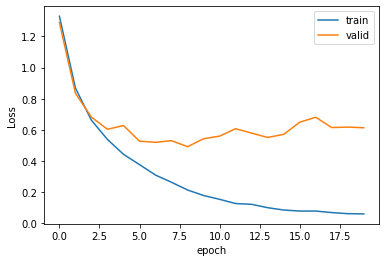

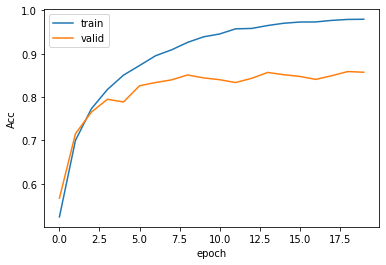

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(res[0], label='train')
plt.plot(res[2], label='valid')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.savefig('fig-res-googlenet-train-validate-loss.pdf')
plt.show()

plt.plot(res[1], label='train')
plt.plot(res[3], label='valid')
plt.xlabel('epoch')
plt.ylabel('Acc')
plt.legend(loc='best')
plt.savefig('fig-res-googlenet-train-validate-acc.pdf')
plt.show()

# save raw data
import numpy
numpy.save('fig-res-googlenet_data.npy', res)

GoogLeNet 加入了更加结构化的 Inception 块使得我们能够使用更大的通道，更多的层，同时也控制了计算量。



## 练习
GoogLeNet 有很多后续的版本，尝试看看论文，并亲自实现，看看有什么不同
* v1：最早的版本  
* v2：加入 batch normalization 加快训练  
* v3：对 inception 模块做了调整  
* v4：基于 ResNet 加入了 残差连接


## 参考资料
* [深入理解GoogLeNet结构](https://zhuanlan.zhihu.com/p/32702031)